# Analisis de Sentimientos en reviews de Amazon
Este notebook tiene como objetivo realizar un análisis de sentimiento sobre un conjunto de datos de reseñas de productos de Amazon.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/rchicangana/icesi_nlp/blob/analisisTexto/Session%201/Taller%201/blob/main/notebooks/7-taller-sentiment-analysis.ipynb)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import sys
import warnings


nltk.download('vader_lexicon')
nltk.download('stopwords')

sns.set(style="whitegrid")

warnings.filterwarnings('ignore')

IN_COLAB = 'google.colab' in sys.modules

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lauraich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lauraich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Descargamos el dataset y el archivo de requerimientos si no existen localmente.


In [20]:
import os

if IN_COLAB:
    # En Colab, creamos la carpeta data y descargamos ahí
    !mkdir -p data
    if not os.path.exists('data/amazon_reviews.csv.zip'):
        !wget -P data/ https://github.com/rchicangana/icesi_nlp/tree/main/Session%201/Taller%201/amazon_reviews.csv.zip
    
    # Los requerimientos se instalan en el entorno
    if not os.path.exists('requirements.txt'):
        !wget https://github.com/rchicangana/icesi_nlp/tree/main/Session%201/Taller%201/requirements.txt
    !pip install -r requirements.txt
else:
    # En local, mantenemos en la raíz
    if not os.path.exists('amazon_reviews.csv.zip'):
        !wget https://github.com/rchicangana/icesi_nlp/tree/main/Session%201/Taller%201/data/amazon_reviews.csv.zip
    if not os.path.exists('requirements.txt'):
        !wget https://github.com/rchicangana/icesi_nlp/tree/main/Session%201/Taller%201/requirements.txt
    %pip install -r requirements.txt



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Carga de Datos
Cargamos el archivo CSV en un DataFrame de Pandas.


In [21]:
# Cargar datos
# Ajustar ruta dependiendo del entorno
data_path = 'data/amazon_reviews.csv.zip' if IN_COLAB else 'amazon_reviews.csv.zip'

df = pd.read_csv(data_path)

# Inspección inicial
print("Dimensiones:", df.shape)
df.head()

Dimensiones: (4915, 12)


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


### Limpieza de Datos
Eliminamos valores nulos para asegurar la calidad de los datos.


In [22]:
# Validar nulos
df.isnull().sum() 

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

Limpiar data, eliminar nulos o textos vacios en las reviews

In [23]:
df.dropna(inplace=True)
df.reviewText = df.reviewText.apply(lambda r: r.lower().strip())
blanks = df[df.reviewText == ''].index
df.drop(blanks, inplace=True)

In [24]:
# Validar nulos
df.isnull().sum() 

Unnamed: 0              0
reviewerName            0
overall                 0
reviewText              0
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64

### Análisis Exploratorio de Datos
Analizamos la distribución de las calificaciones (estrellas) para entender el balance del dataset.


Conteo de valores por etiqueta: overall
5.0    3921
4.0     526
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64


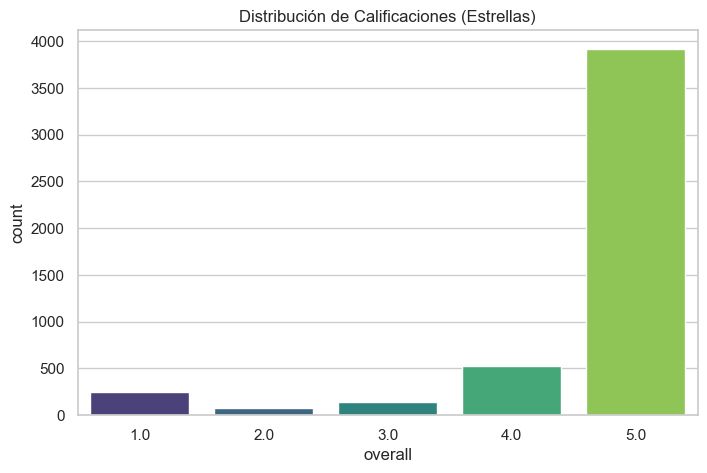

In [25]:
print("Conteo de valores por etiqueta:", df.overall.value_counts())

# Ver distribución de estrellas
plt.figure(figsize=(8,5))
sns.countplot(x='overall', data=df, palette='viridis')
plt.title('Distribución de Calificaciones (Estrellas)')
plt.show()

Se puede observar que hay un desbalance en el puntaje de estrellas, ya que la mayoria son 5 y la menor cantidad es 2. Esto puede llegar a ser típico en Amazon ya que la gente suele comprar cosas buenas, pero este desbalance es un reto para cualquier modelo de clasificación.

### Análisis de Bigramas
Examinamos los pares de palabras más frecuentes para identificar temas comunes en las reseñas.


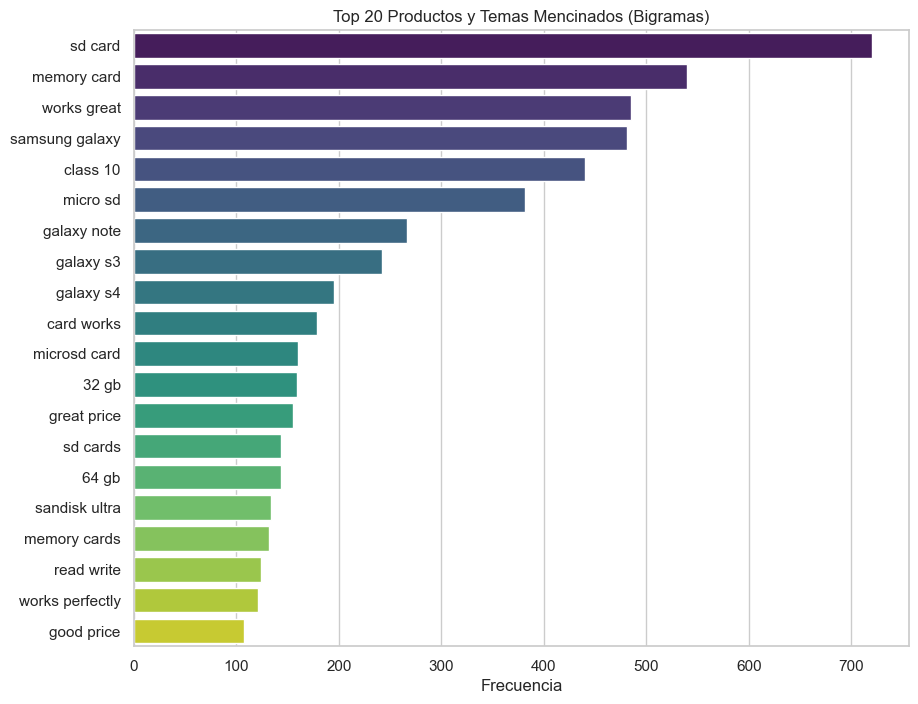

In [26]:
def get_top_ngrams(corpus, n=None, n_gram_range=(2, 2)):
    # Convertimos a string y eliminamos nulos
    corpus = corpus.dropna().astype(str)
    
    vec = CountVectorizer(ngram_range=n_gram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# Obtener los top 20 pares de palabras (Bigramas)
top_bigrams = get_top_ngrams(df['reviewText'], n=20, n_gram_range=(2, 2))
x, y = map(list, zip(*top_bigrams))

# Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x=y, y=x, palette='viridis')
plt.title('Top 20 Productos y Temas Mencinados (Bigramas)')
plt.xlabel('Frecuencia')
plt.show()

A través del análisis de bigramas, se determinó que el dataset no es genérico, sino específico de productos tecnológicos.

### Etiquetado de Sentimiento
Convertimos las estrellas en etiquetas de sentimiento:
* 1-2 Estrellas -> Negativo
* 4-5 Estrellas -> Positivo
* 3 Estrellas -> Neutro (Se descartan para este análisis)

Se eliminará la etiqueta neutral para reducir el ruido y enfocar el modelo en detectar polaridad clara

In [27]:
# Crear etiquetas
def get_sentiment_label(score):
    if score > 3:
        return 'pos'
    elif score < 3:
        return 'neg'
    else:
        return 'neutral'

df['label'] = df['overall'].apply(get_sentiment_label)

# Eliminar neutros 
df = df[df['label'] != 'neutral']

print("Distribución final de etiquetas:")
print(df['label'].value_counts())

Distribución final de etiquetas:
label
pos    4447
neg     324
Name: count, dtype: int64


In [28]:
sid = SentimentIntensityAnalyzer()

# Calcular scores
df['scores'] = df['reviewText'].apply(lambda review: sid.polarity_scores(str(review)))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['prediction'] = df['compound'].apply(lambda c: 'pos' if c > 0 else 'neg')

df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,label,scores,compound,prediction
1,1,0mie,5.0,"purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,pos,"{'neg': 0.075, 'neu': 0.925, 'pos': 0.0, 'comp...",-0.2960,neg
2,2,1K3,4.0,it works as expected. i should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,pos,"{'neg': 0.077, 'neu': 0.923, 'pos': 0.0, 'comp...",-0.3089,neg
3,3,1m2,5.0,this think has worked out great.had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,pos,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.7081,pos
4,4,2&amp;1/2Men,5.0,"bought it with retail packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,pos,"{'neg': 0.038, 'neu': 0.835, 'pos': 0.127, 'co...",0.7087,pos
5,5,2Cents!,5.0,it's mini storage. it doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,pos,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neg


### Longitud de la Reseña vs Sentimiento
Comparamos la longitud de las reseñas positivas vs negativas.


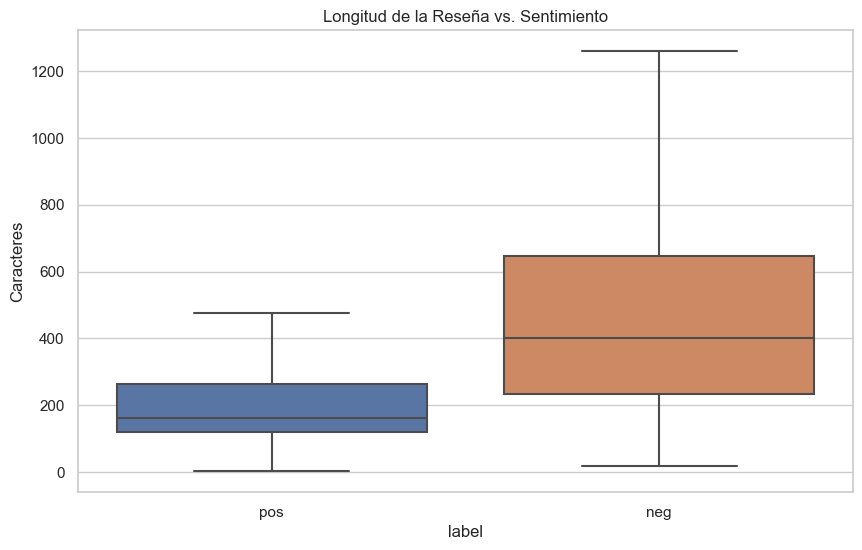

In [29]:
# Calcular longitud
df['length'] = df['reviewText'].astype(str).apply(len)

# Visualizar
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='length', data=df, showfliers=False) # showfliers=False oculta outliers extremos para ver mejor la media
plt.title('Longitud de la Reseña vs. Sentimiento')
plt.ylabel('Caracteres')
plt.show()

Se observa que las reseñas negativas son mucho más largas (media aprox 400 caracteres) que las positivas (aprox 180 caracteres). Los usuarios insatisfechos tienden a escribir explicaciones detalladas de fallos, mientras que los felices son breves.

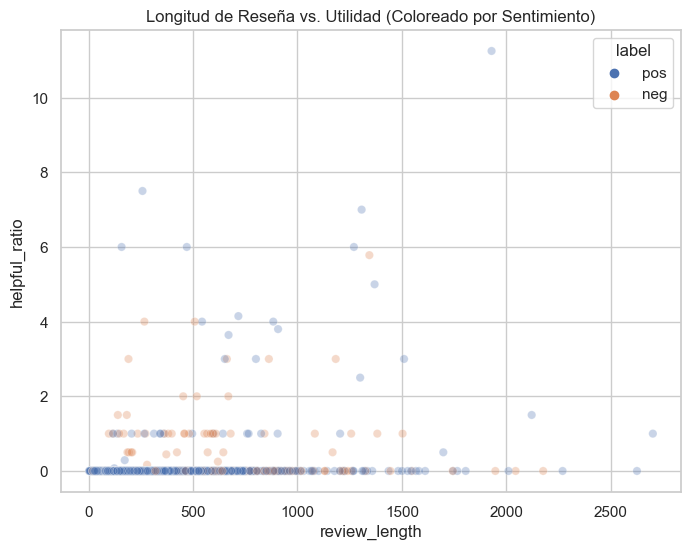

In [30]:
# Calcular ratio de utilidad
df['helpful_ratio'] = df['helpful_yes'] / df['helpful_no']
df['helpful_ratio'] = df['helpful_ratio'].fillna(0) # Manejar división por cero

# Ver si hay correlación entre longitud del texto y utilidad
df['review_length'] = df['reviewText'].apply(len)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='review_length', y='helpful_ratio', hue='label', alpha=0.3, data=df[df['review_length'] < 3000])
plt.title('Longitud de Reseña vs. Utilidad (Coloreado por Sentimiento)')
plt.show()

Se puede observar que a las personas les resulta más util las reseñas tanto positivas cómo negativas que no son tan extensas.

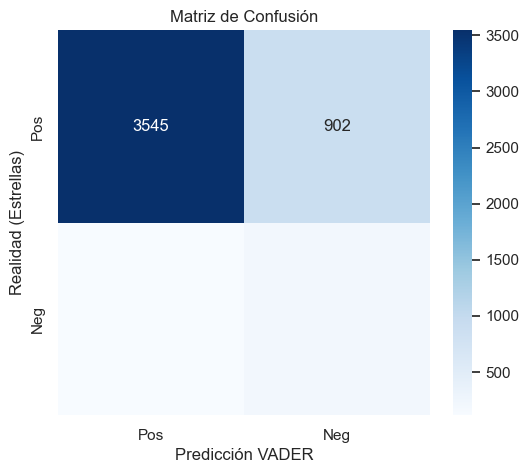

              precision    recall  f1-score   support

         neg       0.19      0.65      0.29       324
         pos       0.97      0.80      0.87      4447

    accuracy                           0.79      4771
   macro avg       0.58      0.72      0.58      4771
weighted avg       0.92      0.79      0.83      4771



In [31]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = df['label']
y_pred = df['prediction']

cm = confusion_matrix(y_true, y_pred, labels=['pos', 'neg'])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pos', 'Neg'], yticklabels=['Pos', 'Neg'])
plt.xlabel('Predicción VADER')
plt.ylabel('Realidad (Estrellas)')
plt.title('Matriz de Confusión')
plt.show()

print(classification_report(y_true, y_pred))

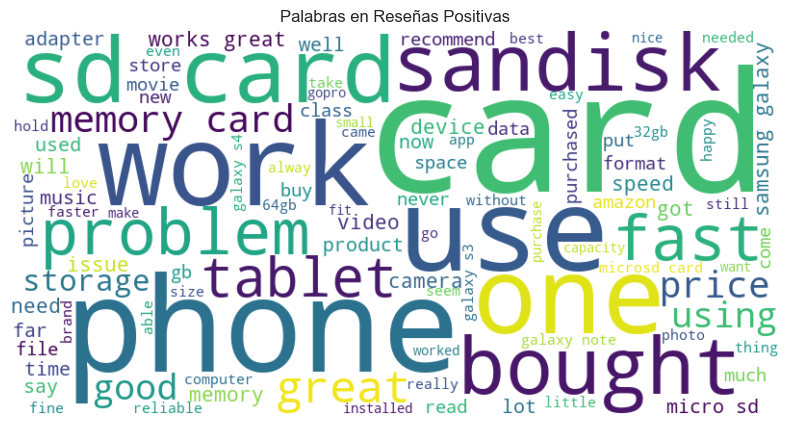

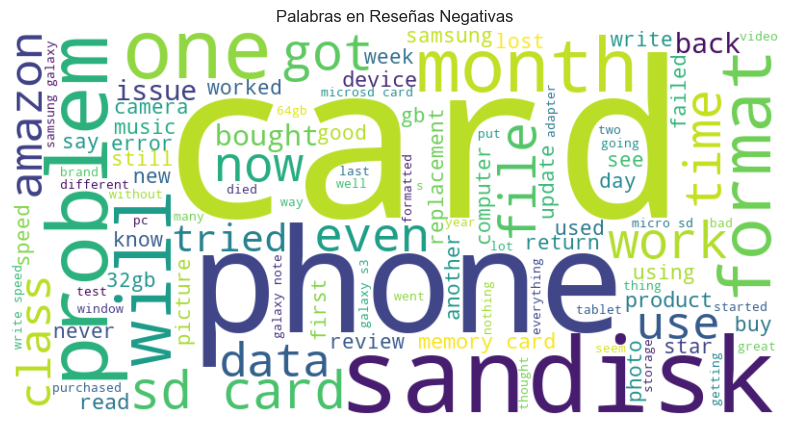

In [32]:
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Unir textos
pos_text = ' '.join(df[df['label']=='pos']['reviewText'].astype(str))
neg_text = ' '.join(df[df['label']=='neg']['reviewText'].astype(str))

plot_wordcloud(pos_text, "Palabras en Reseñas Positivas")
plot_wordcloud(neg_text, "Palabras en Reseñas Negativas")

**En la Nube Positiva:** Predominan adjetivos de satisfacción y velocidad. Se ven palabras grandes como "Great", "Fast", "Good", "Price", "Works".

Es decir que los usuarios felices van al grano. Valoran que el producto cumpla su función ("Works") y la relación calidad-precio ("Price").

**En la Nube Negativa:** Predominan verbos de fallo y términos de uso del producto. Se ven palabras cómo "Error", "Died", "Lost", "Problem", "Back", "Format".

Pero también se ven palabras sustantivas como "Card", "Memory", "Phone", "Samsung", "Amazon" aparecen gigantes en ambas nubes.

Esto demuestra que el sentimiento no está en el objeto, sino en lo que le sucede (funciona vs. muere). Un modelo simple de conteo de palabras a veces no capta esa sutileza si no analiza el contexto.

## Conclusiones

- Existe una correlación inversa entre la polaridad del sentimiento y la longitud de la reseña. Las reseñas negativas presentan una media de caracteres significativamente superior en comparación con las positivas.

- La mayoría de las reseñas del dataset son positivas (93%). Esto hace que el modelo tienda a predecir casi siempre “positivo”, lo que genera un sesgo y dificulta evaluar realmente su desempeño.

- Aunque el modelo obtuvo una exactitud general del 79%, no identifica bien las reseñas negativas. Detecta algunas quejas (Recall moderado), pero muchas veces clasifica como negativas reseñas que no lo son o no logra identificarlas correctamente (Precisión baja de 0.19).

- El modelo VADER fue útil, pero tiene una limitación importante: como se basa en un diccionario general de palabras, no entiende bien términos técnicos como “format” o “write speed”. Al no tener palabras emocionales explícitas, puede interpretar mal el sentimiento real de la reseña.